#18266401 Lab 5
Made using Google Colab by Ayoub Jdair

Excersise Goal: Dimentionality Reduction

#Imports

In [229]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

# imports necessary for dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn import svm
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE
from sklearn.decomposition import FactorAnalysis as FA

# regression algorithms
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline

# metrics for evaluating regression models
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from google.colab import drive


#Task 2
In this exercise, I aim to train a regression model for predicting the insruance cost of a file from its other characteristics

In [278]:
#EDA
drive.mount('/content/MyDrive')
df = pd.read_csv('insurance.csv')
old_df = df
df.head(5)

Drive already mounted at /content/MyDrive; to attempt to forcibly remount, call drive.mount("/content/MyDrive", force_remount=True).


,age,gender,bmi,children,smoker,region,insurance_cost
0,18,male,33.770,1,no,southeast,1725.55230
1,18,male,34.100,0,no,southeast,1137.01100
2,18,female,26.315,0,no,northeast,2198.18985
3,18,female,38.665,2,no,northeast,3393.35635
4,18,female,35.625,0,no,northeast,2211.13075


In [279]:
df.tail(5)

,age,gender,bmi,children,smoker,region,insurance_cost
1333,64,female,31.825,2,no,northeast,16069.08475
1334,64,female,26.885,0,yes,northwest,29330.98315
1335,64,male,26.410,0,no,northeast,14394.55790
1336,64,male,36.960,2,yes,southeast,49577.66240
1337,64,male,23.760,0,yes,southeast,26926.51440


In [280]:
df['region'].value_counts()

southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64

In [281]:
df.isna().sum()

age               0
gender            0
bmi               0
children          0
smoker            0
region            0
insurance_cost    0
dtype: int64

In [282]:
df.describe()

,age,bmi,children,insurance_cost
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


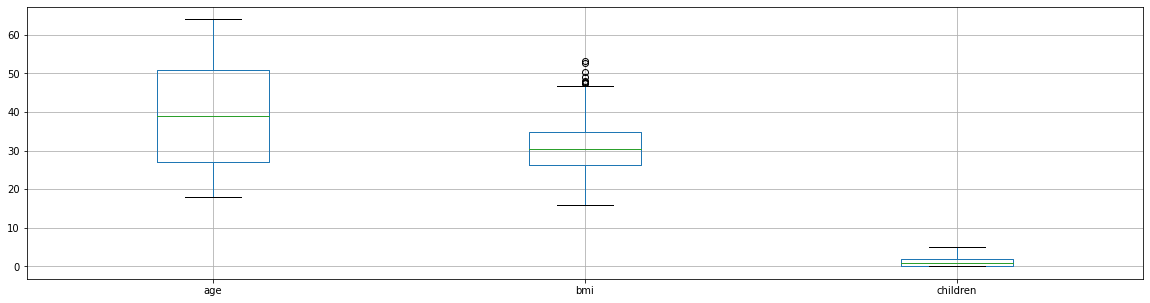

In [283]:
df.drop('insurance_cost', axis=1).boxplot(figsize=(20,5))
plt.show()

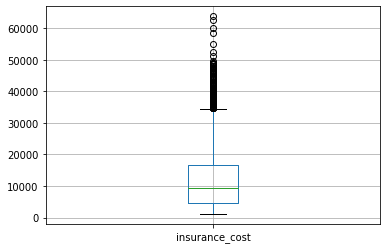

In [284]:
df.boxplot(column=['insurance_cost'])
plt.show()

In [285]:
df = pd.get_dummies(df, columns=['region', 'gender', 'smoker'])

In [286]:
df.head()

,age,bmi,children,insurance_cost,region_northeast,region_northwest,region_southeast,region_southwest,gender_female,gender_male,smoker_no,smoker_yes
0,18,33.770,1,1725.55230,0,0,1,0,0,1,1,0
1,18,34.100,0,1137.01100,0,0,1,0,0,1,1,0
2,18,26.315,0,2198.18985,1,0,0,0,1,0,1,0
3,18,38.665,2,3393.35635,1,0,0,0,1,0,1,0
4,18,35.625,0,2211.13075,1,0,0,0,1,0,1,0


In [287]:
df.tail()

,age,bmi,children,insurance_cost,region_northeast,region_northwest,region_southeast,region_southwest,gender_female,gender_male,smoker_no,smoker_yes
1333,64,31.825,2,16069.08475,1,0,0,0,1,0,1,0
1334,64,26.885,0,29330.98315,0,1,0,0,1,0,0,1
1335,64,26.410,0,14394.55790,1,0,0,0,0,1,1,0
1336,64,36.960,2,49577.66240,0,0,1,0,0,1,0,1
1337,64,23.760,0,26926.51440,0,0,1,0,0,1,0,1


In [288]:
preprocess_pipeline = make_pipeline(StandardScaler())

In [289]:
y = df['insurance_cost']
X = df.drop('insurance_cost', axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [290]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('regresson', RandomForestRegressor(n_estimators=10))])

In [291]:
N_FEATURES_OPTIONS = [2, 6, 11]
MAX_DEPTH_OPTIONS = [2, 4, 6, 8]

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__max_depth': MAX_DEPTH_OPTIONS
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'regresson__max_depth': MAX_DEPTH_OPTIONS
    }  
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
RF_best_params = search.best_params_
RF_best_model = search.best_estimator_

Best CV score = 0.851:
Best parameters:  {'reduce_dim': RFE(estimator=SVR(gamma='auto', kernel='linear'), n_features_to_select=6), 'reduce_dim__n_features_to_select': 6, 'regresson__max_depth': 4}


In [292]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('regresson', LinearRegression())])

In [293]:
import warnings
warnings.filterwarnings('ignore')

N_FEATURES_OPTIONS = [2, 6, 11]
NORMALIZE_OPTIONS = [False, True]

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__normalize': NORMALIZE_OPTIONS
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'regresson__normalize': NORMALIZE_OPTIONS
    }  
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
LR_best_params = search.best_params_
LR_best_model = search.best_estimator_

Best CV score = 0.745:
Best parameters:  {'reduce_dim': RFE(estimator=SVR(gamma='auto', kernel='linear'), n_features_to_select=6), 'reduce_dim__n_features_to_select': 6, 'regresson__normalize': True}


In [294]:
def evaluate_model(X_test, y_test, model):
    
    _predicted_values = model.predict(X_test)
        
    _mse = mean_squared_error(y_test, _predicted_values)
    _mae = mean_absolute_error(y_test, _predicted_values)
    _r2 = r2_score(y_test, _predicted_values)
            
    return _mse, _mae, _r2

In [295]:
RF_mse, RF_mae, RF_r2 = evaluate_model(X_test, y_test, RF_best_model)
LR_mse, LR_mae, LR_r2 = evaluate_model(X_test, y_test, LR_best_model)

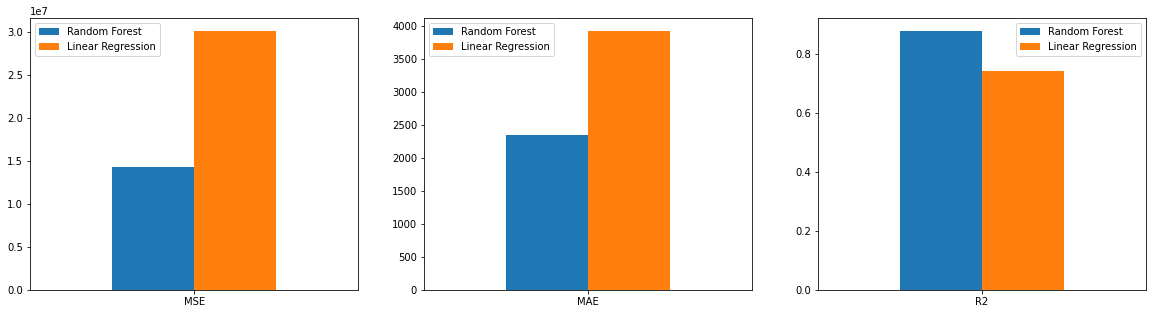

In [296]:
df_mse = pd.DataFrame({'Random Forest': RF_mse, 'Linear Regression': LR_mse}, index=['MSE'])
df_mae = pd.DataFrame({'Random Forest': RF_mae, 'Linear Regression': LR_mae}, index=['MAE'])
df_r2 = pd.DataFrame({'Random Forest': RF_r2, 'Linear Regression': LR_r2}, index=['R2'])

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

df_mse.plot.bar(rot=0, ax=axes[0])
df_mae.plot.bar(rot=0, ax=axes[1])
df_r2.plot.bar(rot=0, ax=axes[2])

plt.show()

From these results we can conclude that Linear Regression preformed better than Random Forest with a lower MSE and MAE and higher R2

In [297]:
rfe = RFE(estimator=DecisionTreeRegressor(), n_features_to_select=5)
model = DecisionTreeRegressor()
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('Decision Tree Regressor',rfe),
                       ('m',model)])

In [298]:
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

In [299]:
model.fit(X_train, y_train)

DecisionTreeRegressor()

In [300]:
DTR_mse, DTR_mae, DTR_r2 = evaluate_model(X_test, y_test, LR_best_model)

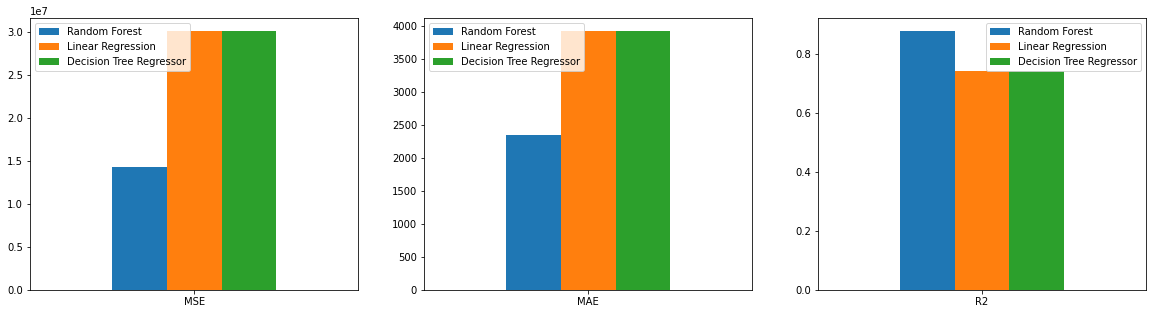

In [301]:
df_mse = pd.DataFrame({'Random Forest': RF_mse, 'Linear Regression': LR_mse, 'Decision Tree Regressor': DTR_mse}, index=['MSE'])
df_mae = pd.DataFrame({'Random Forest': RF_mae, 'Linear Regression': LR_mae, 'Decision Tree Regressor': DTR_mae}, index=['MAE'])
df_r2 = pd.DataFrame({'Random Forest': RF_r2, 'Linear Regression': LR_r2, 'Decision Tree Regressor': DTR_r2}, index=['R2'])

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

df_mse.plot.bar(rot=0, ax=axes[0])
df_mae.plot.bar(rot=0, ax=axes[1])
df_r2.plot.bar(rot=0, ax=axes[2])

plt.show()

Baed on the above results, Linear regression performed similarly to Decision tree regression, and they both our preformed Random forest. RF scored lower than the latter on MSE & MAE, and exibited a higher R2

Decision Trees generally support non-linearity while Linear Regression better suits linear situations.

#Task 3

In [272]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('regresson', RandomForestRegressor(n_estimators=10))])

In [273]:
N_FEATURES_OPTIONS = [2, 6, 11]
MAX_DEPTH_OPTIONS = [2, 4, 6, 8]

param_grid = [
    {
        'reduce_dim': [FA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__max_depth': MAX_DEPTH_OPTIONS
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'regresson__max_depth': MAX_DEPTH_OPTIONS
    }  
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
RF_best_params = search.best_params_
RF_best_model = search.best_estimator_

Best CV score = 0.855:
Best parameters:  {'reduce_dim': RFE(estimator=LinearRegression(), n_features_to_select=6), 'reduce_dim__n_features_to_select': 6, 'regresson__max_depth': 4}


In [274]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('regresson', LinearRegression())])

In [275]:
import warnings
warnings.filterwarnings('ignore')

N_FEATURES_OPTIONS = [2, 6, 11]
NORMALIZE_OPTIONS = [False, True]

param_grid = [
    {
        'reduce_dim': [TSNE(n_components=2, learning_rate='auto', init='random')],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__normalize': NORMALIZE_OPTIONS
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'regresson__normalize': NORMALIZE_OPTIONS
    }  
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
LR_best_params = search.best_params_
LR_best_model = search.best_estimator_

Best CV score = 0.743:
Best parameters:  {'reduce_dim': RFE(estimator=SVR(gamma='auto', kernel='linear'), n_features_to_select=11), 'reduce_dim__n_features_to_select': 11, 'regresson__normalize': False}


In [276]:
Updated_RF_mse, Updated_RF_mae, Updated_RF_r2 = evaluate_model(X_test, y_test, RF_best_model)
Updated_LR_mse, Updated_LR_mae, Updated_LR_r2 = evaluate_model(X_test, y_test, LR_best_model)

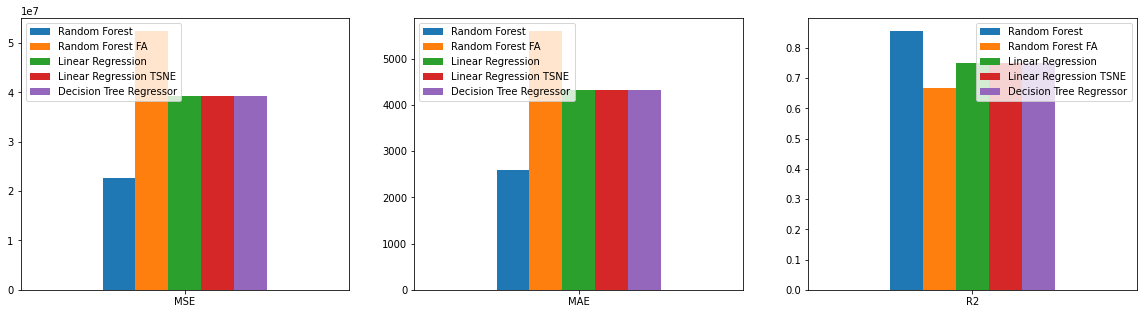

In [277]:
df_mse = pd.DataFrame({'Random Forest': RF_mse, 'Random Forest FA': Updated_RF_mse, 'Linear Regression': LR_mse, 'Linear Regression TSNE': Updated_LR_mse, 'Decision Tree Regressor': DTR_mse}, index=['MSE'])
df_mae = pd.DataFrame({'Random Forest': RF_mae, 'Random Forest FA': Updated_RF_mae, 'Linear Regression': LR_mae, 'Linear Regression TSNE': Updated_LR_mae, 'Decision Tree Regressor': DTR_mae}, index=['MAE'])
df_r2 = pd.DataFrame({'Random Forest': RF_r2,'Random Forest FA': Updated_RF_r2, 'Linear Regression': LR_r2, 'Linear Regression TSNE': Updated_LR_r2, 'Decision Tree Regressor': DTR_r2}, index=['R2'])

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

df_mse.plot.bar(rot=0, ax=axes[0])
df_mae.plot.bar(rot=0, ax=axes[1])
df_r2.plot.bar(rot=0, ax=axes[2])

plt.show()

For part 3 of this lab i used Factor Analysis (FA) and t-distributed Stochastic Neighbor Embedding (TSNE). 

Factor Analysis (FA) is comparable to PCA wherein they both work for dimensionality reduction, the difference lies in the naming of FA. The 'Factor' in FA stems from this method's usefulness in identifying latent attributes which cannot be directly measured in individual attributes but rather are implied in a number of attributes from the Data set. These are known as 'Factors'.

TSNE is a non-linear dimensionality reduction tool commonly used in image processing.

In terms of the above results, we can see a an increase in the MSE & MAE for random forest when we use FA and a decrease in R2. so random forest did not benefit from FA in this case. LR on the otherhand sees a slight increase in MSE and MAE scores and a decrease in R2. Changes overall are minimal but noteworhy, I suspect this is due to the structure of our dataset and number of features.